Data loaded successfully from: resources\tcc_ceds_music.csv
Columns in the CSV: ['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience', 'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places', 'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy', 'topic', 'age']
Original CSV data backed up as: resources\original_tcc_ceds_music.csv
Raw data stored in SQL database at: resources\music_lyrics.db
Lyric cleaning complete.
Sentiment scores calculated using TextBlob.
Processed data saved to: resources\processed_tcc_ceds_music.csv
Processed music data stored in SQL.
Sentiment Model Accuracy: 0.8662555066079295
Sentiment Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      2128
  

c:\Users\olive\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Genre Model Accuracy: 0.39312775330396477
Genre Classification Report:
               precision    recall  f1-score   support

       blues       0.33      0.28      0.30       926
     country       0.46      0.55      0.50      1123
     hip hop       0.65      0.38      0.48       198
        jazz       0.36      0.29      0.32       731
         pop       0.35      0.50      0.41      1398
      reggae       0.57      0.30      0.39       515
        rock       0.38      0.28      0.33       784

    accuracy                           0.39      5675
   macro avg       0.44      0.37      0.39      5675
weighted avg       0.40      0.39      0.39      5675



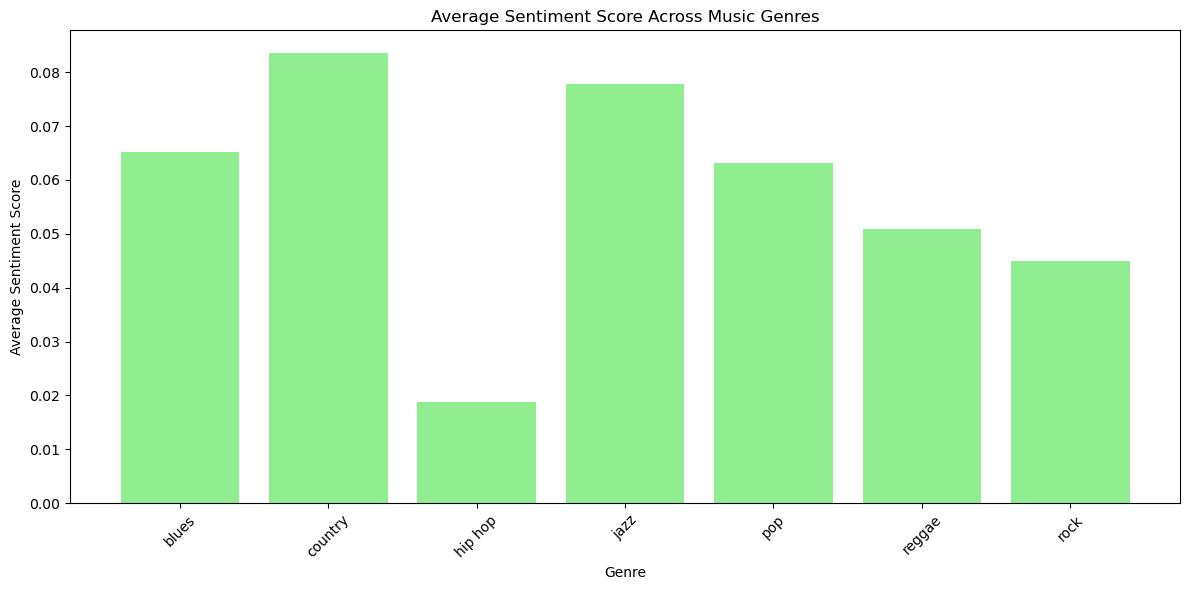

Models saved successfully.
SQL connection closed.


In [1]:
# music_analyzer.py

# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import re
import sqlite3
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import pickle

# Uncomment if needed
# !pip install wordcloud
# !pip install textblob
# !pip install nltk
# nltk.download('stopwords')

# --- STEP 2: Data Acquisition for New Dataset ---
data_file_path = os.path.join("resources", "tcc_ceds_music.csv")
df = pd.read_csv(data_file_path)

print("Data loaded successfully from:", data_file_path)
print("Columns in the CSV:", df.columns.tolist())

# Create a copy so that the base data remains unchanged
df_processed = df.copy()

# Back up the original CSV data for safekeeping
original_csv_backup = os.path.join("resources", "original_tcc_ceds_music.csv")
df.to_csv(original_csv_backup, index=False)
print("Original CSV data backed up as:", original_csv_backup)

# Connect to a SQLite database (database stored in the resources folder)
db_path = os.path.join("resources", "music_lyrics.db")
conn = sqlite3.connect(db_path)
df_processed.to_sql("raw_music", conn, if_exists="replace", index=False)
print("Raw data stored in SQL database at:", db_path)

# --- STEP 3: Text Preprocessing ---
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation via regex
    text = re.sub(r"[^\w\s]", "", text)
    # Tokenize and remove stop words
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Make sure the dataset has a 'lyrics' column
if "lyrics" not in df_processed.columns:
    raise KeyError("The dataset must have a column named 'lyrics'. Please update the code accordingly.")

df_processed["clean_lyrics"] = df_processed["lyrics"].apply(lambda x: clean_text(str(x)))
print("Lyric cleaning complete.")

# --- STEP 4: Sentiment Analysis using TextBlob ---
def get_sentiment(text):
    # Polarity ranges from -1 (negative) to 1 (positive)
    return TextBlob(text).sentiment.polarity

df_processed["sentiment_score"] = df_processed["clean_lyrics"].apply(get_sentiment)
print("Sentiment scores calculated using TextBlob.")

# Create a binary sentiment label: 1 for positive/neutral, 0 for negative.
df_processed["sentiment_label"] = df_processed["sentiment_score"].apply(lambda x: 1 if x >= 0 else 0)

# --- STEP 5: Additional Inferences ---
# For example, we can also use the provided genre column.
if "genre" not in df_processed.columns:
    raise KeyError("Expected a 'genre' column in the dataset.")

# --- STEP 6: Save Processed Data ---
processed_csv_path = os.path.join("resources", "processed_tcc_ceds_music.csv")
df_processed.to_csv(processed_csv_path, index=False)
print("Processed data saved to:", processed_csv_path)

df_processed.to_sql("processed_music", conn, if_exists="replace", index=False)
print("Processed music data stored in SQL.")

# --- STEP 7: Train Machine Learning Models ---

## (A) Sentiment Model Training (Binary Classification)
# Use TF-IDF on cleaned lyrics.
tfidf_sentiment = TfidfVectorizer(max_features=5000, stop_words='english')
X_sentiment = tfidf_sentiment.fit_transform(df_processed["clean_lyrics"])
y_sentiment = df_processed["sentiment_label"]

X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(X_sentiment, y_sentiment,
                                                                      test_size=0.2, random_state=42)
sentiment_model = LogisticRegression(max_iter=1000, random_state=42)
sentiment_model.fit(X_train_sent, y_train_sent)

y_pred_sent = sentiment_model.predict(X_test_sent)
print("Sentiment Model Accuracy:", accuracy_score(y_test_sent, y_pred_sent))
print("Sentiment Classification Report:\n", classification_report(y_test_sent, y_pred_sent))

## (B) Genre Prediction Model Training (Multi-Class Classification)
# Use the genre column as labels.
# Note: Clean the genre string if needed.
df_processed["genre"] = df_processed["genre"].astype(str)
tfidf_genre = TfidfVectorizer(max_features=5000, stop_words='english')
X_genre = tfidf_genre.fit_transform(df_processed["clean_lyrics"])
y_genre = df_processed["genre"]

X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X_genre, y_genre,
                                                                            test_size=0.2, random_state=42)
genre_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
genre_model.fit(X_train_genre, y_train_genre)

y_pred_genre = genre_model.predict(X_test_genre)
print("Genre Model Accuracy:", accuracy_score(y_test_genre, y_pred_genre))
print("Genre Classification Report:\n", classification_report(y_test_genre, y_pred_genre))

# --- STEP 8: Visualizations (Optional) ---
# For instance, plotting the average sentiment by genre
if "genre" in df_processed.columns:
    group_sentiment = df_processed.groupby("genre")["sentiment_score"].mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(group_sentiment["genre"], group_sentiment["sentiment_score"], color="lightgreen")
    plt.xlabel("Genre")
    plt.ylabel("Average Sentiment Score")
    plt.title("Average Sentiment Score Across Music Genres")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- STEP 9: Save Models with Pickle ---
resources_folder = "resources"
with open(os.path.join(resources_folder, "tfidf_sentiment.pkl"), "wb") as f:
    pickle.dump(tfidf_sentiment, f)
with open(os.path.join(resources_folder, "sentiment_model.pkl"), "wb") as f:
    pickle.dump(sentiment_model, f)

with open(os.path.join(resources_folder, "tfidf_genre.pkl"), "wb") as f:
    pickle.dump(tfidf_genre, f)
with open(os.path.join(resources_folder, "genre_model.pkl"), "wb") as f:
    pickle.dump(genre_model, f)

print("Models saved successfully.")

# --- STEP 10: Close Database Connection ---
conn.close()
print("SQL connection closed.")
